In [8]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [9]:
provider = IBMQ.load_account()

C:\Users\tlbk\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


In [10]:
#functions

# def OR(a, b, k):
#     # enter qubit numbers here 
#     """ function does the equivalent of a classical OR between nodes a and b and stores the result in k """
#     qc.barrier(q)
#     qc.cx(q[a], q[k])
#     qc.barrier(q)
#     qc.x(q[a])
#     qc.barrier(q)
#     qc.ccx(q[a], q[b], q[k])
#     qc.barrier(q)
#     qc.x(q[a])
#     qc.barrier(q)

def OR(qubit_1, qubit_2, k):
    # enter qubit numbers here 
    """ function does the equivalent of a classical OR between qubit numbers a and b and stores the result in qubit number k """
    qc.barrier(q)
    qc.x(q[qubit_1])
    qc.x(q[qubit_2])
    qc.barrier(q)
    qc.ccx(q[qubit_1], q[qubit_2], q[k])
    qc.x(q[k])
    qc.barrier(q)
    qc.x(q[qubit_1])
    qc.x(q[qubit_2])
    qc.barrier(q)
    

def are_not_equal(a_0, b_0, k):
    # enter node numbers here. For example, a is node 0, b is node 1 and c is node 2
    """ function outputs 1 if nodes a and b are not the same. Node numbering starts from 0
        as in the problem statement. k is the qubit number where the output is XOR-ed. qubit
        numbering also starts from 0 """
    qc.barrier(q)
    qc.cx(q[2*a_0], q[2*b_0])
    qc.cx(q[(2*a_0) + 1], q[(2*b_0) + 1])
    OR(2*b_0, (2*b_0)+1, k)
    qc.cx(q[2*a_0], q[2*b_0])
    qc.cx(q[(2*a_0) + 1], q[(2*b_0) + 1])
    qc.barrier(q)

In [11]:
# number of nodes 
n = 4

def initialize_oracle_part(n):
    t = 2*(n-1)
    qc.h(q[0:t])
    qc.barrier(q)
    are_not_equal(0, 1, 6) # node a and b are not equal 
    are_not_equal(0, 2, 7)
    are_not_equal(1, 2, 8)
    qc.barrier(q)
    qc.mct([q[6], q[7], q[8]], q[10],[q[9]]) # answer is stored in 10. please keep 9 a clean qubit, it's used as ancilla here 
    qc.barrier(q)
    are_not_equal(0, 1, 6) # node a and b are not equal 
    are_not_equal(0, 2, 7)
    are_not_equal(1, 2, 8)
    

In [24]:
## distance_black_box
distances = {
    "32": 3,
    "31": 2,
    "30": 4,
    "21": 7,
    "20": 6,
    "10": 5,
}

def dist_single():
    qr = QuantumRegister(2)
    qr_target = QuantumRegister(3)
    qc = QuantumCircuit(qr, qr_target)
    
    for edge in distances:
        if edge[0] == '3':
            node = format(int(edge[1]), 'b')
            d_bin = format(distances[edge], 'b')
            
            for idx in range(len(node)):
                if node[idx] == '0':
                    qc.x(qr[idx])
            
            for idx in range(len(d_bin)):
                if d_bin[idx] == '1':
                    qc.ccx(qr[0], qr[1], qr_target[idx])
            
            for idx in range(len(node)):
                if node[idx] == '0':
                    qc.x(qr[idx])
    
    return qc

def dist():
    qr1 = QuantumRegister(2)
    qr2 = QuantumRegister(2)
    qr_target = QuantumRegister(3)
    qr_anc = QuantumRegister(2)
    qc = QuantumCircuit(qr1, qr2, qr_target, qr_anc)
    
    for edge in distances:
        if edge[0] != '3':
            # convert to binaries
            node1 = format(int(edge[0]), 'b')
            node2 = format(int(edge[1]), 'b')
            d_bin = format(distances[edge], 'b')

            for idx in range(len(node1)): # assume node1 and node2 have the same length
                if node1[idx] == '0':
                    qc.x(qr1[idx])
                    
            for idx in range(len(node2)):
                if node2[idx] == '0':
                    qc.x(qr2[idx])

            for idx in range(len(d_bin)):
                if d_bin[idx] == '1':
                    qc.mct(qr1[:]+qr2[:], qr_target[idx], qr_anc)
                    
            for idx in range(len(node2)): # invert back
                if node2[idx] == '0':
                    qc.x(qr2[idx])

            for idx in range(len(node1)):
                if node1[idx] == '0':
                    qc.x(qr1[idx])
                
    return qc

In [13]:
## multi_adder_1
def maj(a, b, k):
    qc.cx(q[k], q[b])
    qc.cx(q[k], q[a])
    qc.ccx(q[a], q[b], q[k])
    
def unmaj(a, b, k):
    qc.ccx(q[a], q[b], q[k])
    qc.cx(q[k], q[a])
    qc.cx(q[a], q[b])
    
def multiple_adder(a, b, c_0, z):
    arr_size = len(a)
    maj(c_0, b[0], a[0])
    for i in range(arr_size-1):
        maj(a[i], b[i+1], a[i+1])
    qc.cx(q[a[arr_size-1]], q[z])
    for i in reversed(range(arr_size-1)):
        unmaj(a[i], b[i+1], a[i+1])
    unmaj(c_0, b[0], a[0])

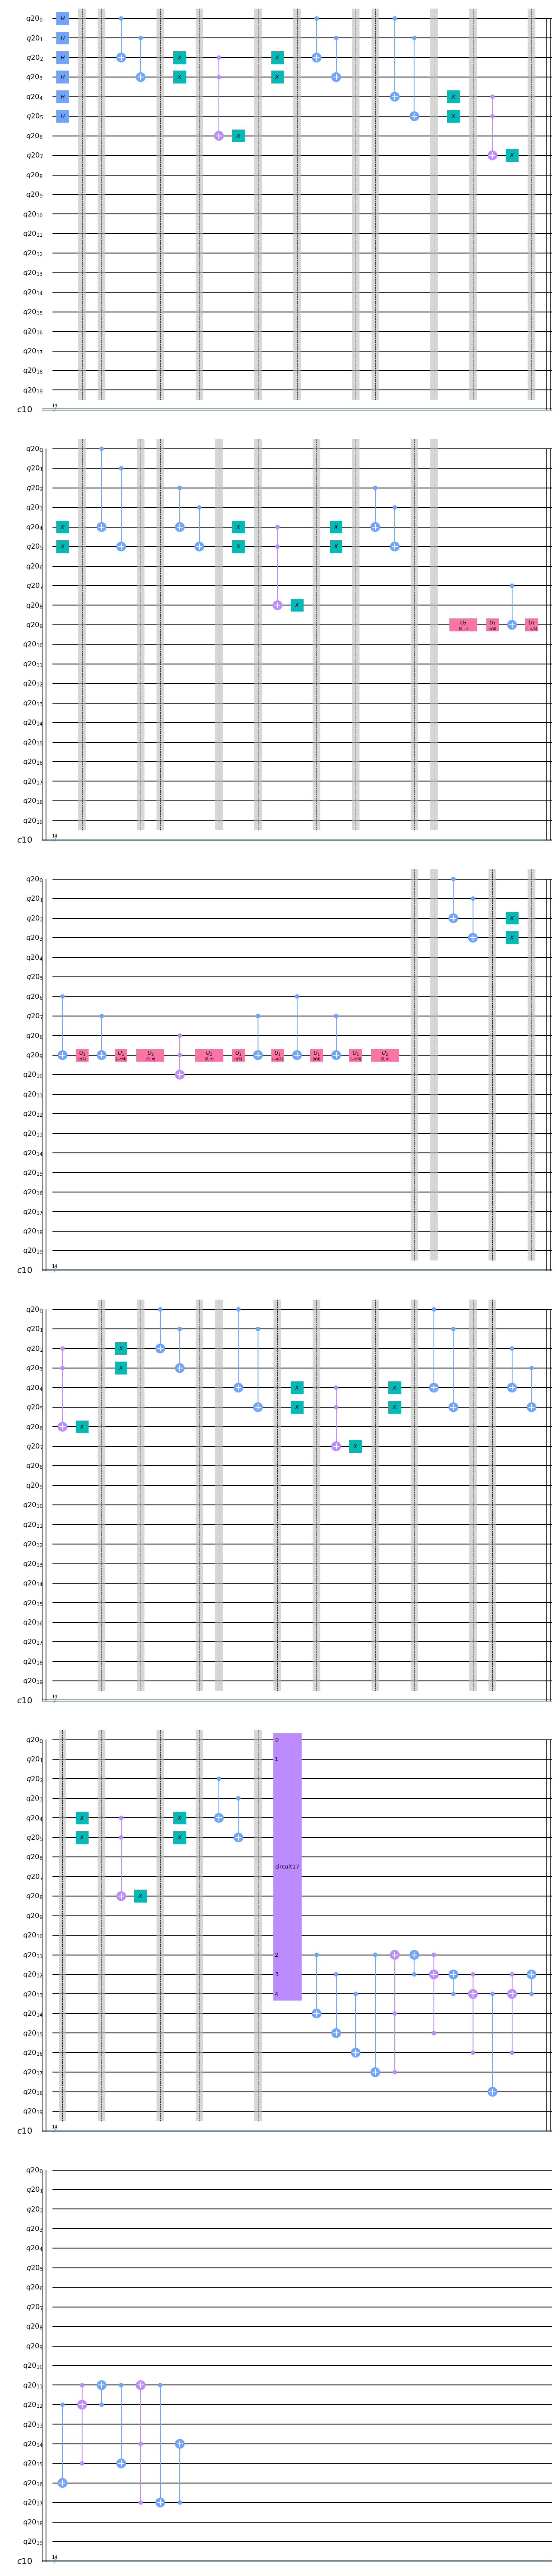

In [28]:
qubit_num = 20  # max is 32 if you're using the simulator 
q = QuantumRegister(qubit_num)
c = ClassicalRegister(14)
qc = QuantumCircuit(q, c)

initialize_oracle_part(4)
qc.append(dist_single(), q[0:2] + q[11:14])
multiple_adder([11, 12, 13], [14, 15, 16], 17, 18) # 14:16 is the dist. register

qc.draw(output='mpl')